#### Purpose of the Notebook

- Analyse the predicted churn probabilities and identify high-risk customers 
- provide insights to business teams for targeted interventions 
- visualise key patterns: demographics, tenure, service usage 
- suggest strategic actions based on predictions 

In [2]:
# import the required libraries 

import pandas as pd
import torch
import os
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

In [13]:
# set paths 

raw_data_dir = '../data/raw/'
processed_data_dir = '../data/processed/'
models_dir = 'models/'

In [21]:
# load customer data 

customers = pd.read_csv(os.path.join(raw_data_dir, 'customer_churn.csv'))

X_test_df = pd.read_csv(os.path.join(processed_data_dir, 'X_test.csv')).values

In [23]:
# Align customers dataframe with X_test
customers = customers.iloc[:X_test_df.shape[0]].copy()
print(f"Number of rows - X_test: {X_test_df.shape[0]}, Customers: {customers.shape[0]}")

Number of rows - X_test: 667, Customers: 667


In [24]:
# Standard scaling 

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_test = scaler.fit_transform(X_test_df)

In [25]:
# convert to PyTorch Tensor 

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

In [26]:
# load the model

class ChurnANN(torch.nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 1),
            torch.nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

input_dim = X_test.shape[1]
model = ChurnANN(input_dim)
model.load_state_dict(torch.load(os.path.join(models_dir, 'best_churn_model.pth')))
model.eval()


ChurnANN(
  (model): Sequential(
    (0): Linear(in_features=13, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [27]:
# generate predictions 

with torch.no_grad():
    y_pred_prob = model(X_test_tensor).numpy()
    y_pred_class = (y_pred_prob >= 0.5).astype(int)

# Merge predictions with customers dataframe
customers['churn_prob'] = y_pred_prob
customers['churn_pred'] = y_pred_class


In [28]:
## Segment customers by risk tiers 


# Divide into 3 tiers: Low, Medium, High
customers['risk_tier'] = pd.qcut(customers['churn_prob'], 3, labels=['Low', 'Medium', 'High'])

# Display risk tier counts
print("Risk Tier Counts:")
print(customers['risk_tier'].value_counts())

Risk Tier Counts:
risk_tier
Low       223
Medium    222
High      222
Name: count, dtype: int64


In [30]:
## Identify high risk customers


high_risk = customers[customers['risk_tier'] == 'High'].sort_values(by='churn_prob', ascending=False)
print("Top 10 High-Risk Customers:")
print(high_risk.head(10)[[ 'churn_prob', 'churn_pred']])

Top 10 High-Risk Customers:
     churn_prob  churn_pred
259    1.000000           1
426    0.999999           1
591    0.999997           1
524    0.999989           1
329    0.999933           1
291    0.999856           1
229    0.999854           1
290    0.999842           1
221    0.999569           1
581    0.999384           1


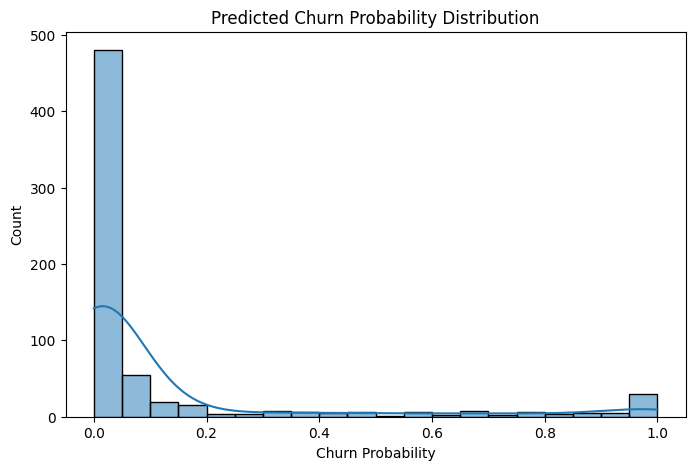

In [31]:
# churn probability distribution 

plt.figure(figsize=(8,5))
sns.histplot(customers['churn_prob'], bins=20, kde=True)
plt.title("Predicted Churn Probability Distribution")
plt.xlabel("Churn Probability")
plt.ylabel("Count")
plt.show()

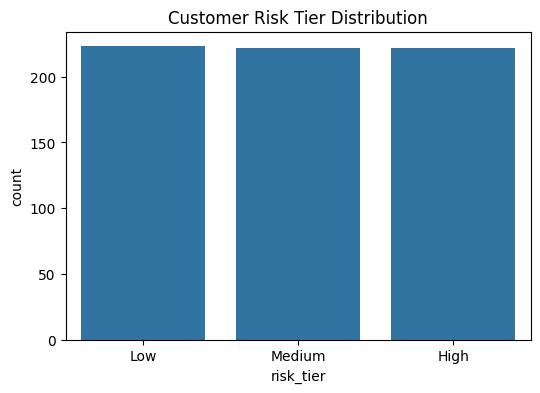

In [32]:
# risk tier distribution 

plt.figure(figsize=(6,4))
sns.countplot(x='risk_tier', data=customers, order=['Low','Medium','High'])
plt.title("Customer Risk Tier Distribution")
plt.show()

In [33]:
# save business insights 

os.makedirs('./models', exist_ok=True)
high_risk.to_csv('./models/high_risk_customers.csv', index=False)
customers.to_csv('./models/customers_with_churn_prob.csv', index=False)

In [34]:
# log into MLFlow

mlflow.set_experiment("Churn_ANN_Business_Insights")
with mlflow.start_run():
    mlflow.log_artifact('./models/high_risk_customers.csv')
    mlflow.log_artifact('./models/customers_with_churn_prob.csv')

2025/12/19 15:37:02 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/19 15:37:02 INFO mlflow.store.db.utils: Updating database tables
2025/12/19 15:37:02 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/19 15:37:02 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/19 15:37:02 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/19 15:37:02 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/19 15:37:02 INFO mlflow.tracking.fluent: Experiment with name 'Churn_ANN_Business_Insights' does not exist. Creating a new experiment.
